In [1]:
import os
import glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset
import cv2
import torchvision.models as models
import pandas as pd

%pip install git+https://github.com/mwalmsley/galaxy_mnist.git

In [2]:
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [57]:
HighRes = False 

if HighRes == False:
    from galaxy_mnist import GalaxyMNIST
    
    #  Import galaxyMNIST dataset
    tv_dataset = GalaxyMNIST(
        root='ML_DP/gal_mnist', #change root with desired folder where to download the catalogue
        download=True,
        train=True  # by default, or False for canonical test set
        )

    test_dataset = GalaxyMNIST(
        root='ML_DP/gal_mnist',  #change root with desired folder where to download the catalogue
        download=True,
        train=False  # by default, or False for canonical test set
        )
if HighRes == True:    
    from galaxy_mnist import GalaxyMNISTHighrez
    
    #  Import galaxyMNISTHighrez dataset
    tv_dataset = GalaxyMNISTHighrez(
        root='ML_DP/gal_mnist', #change root with desired folder where to download the catalogue
        download=True,
        train=True  # by default, or False for canonical test set
    )

    test_dataset = GalaxyMNISTHighrez(
        root='ML_DP/gal_mnist', #change root with desired folder where to download the catalogue
        download=True,
        train=False  # by default, or False for canonical test set
    )

  Cloning https://github.com/mwalmsley/galaxy_mnist.git to /tmp/pip-req-build-t0u40wvs
  Running command git clone --filter=blob:none --quiet https://github.com/mwalmsley/galaxy_mnist.git /tmp/pip-req-build-t0u40wvs
  Resolved https://github.com/mwalmsley/galaxy_mnist.git to commit 375e0257bfd41acbcb7ba2e0f33c8c04d0d5beef
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [59]:
#Splitting the dataset in train, validation and test sets

tv_images = tv_dataset.data
tv_labels = tv_dataset.targets

test_images = test_dataset.data
test_labels = test_dataset.targets


# Split in validation and train datasets
# images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val  = train_test_split(tv_images, tv_labels, shuffle=True, test_size=0.25, random_state=123)

# Create PyTorch dataset
train_dataset = TensorDataset(images_train, y_train)
val_dataset = TensorDataset(images_val, y_val)
test_dataset = TensorDataset(test_images, test_labels)

100%|██████████| 900487097/900487097 [00:38<00:00, 23695990.54it/s]


Extracting ML_DP/gal_mnist/GalaxyMNISTHighrez/raw/train_dataset.hdf5.gz to ML_DP/gal_mnist/GalaxyMNISTHighrez/raw


100%|██████████| 225656501/225656501 [00:02<00:00, 81374782.32it/s] 


Extracting ML_DP/gal_mnist/GalaxyMNISTHighrez/raw/test_dataset.hdf5.gz to ML_DP/gal_mnist/GalaxyMNISTHighrez/raw


In [60]:
#selecting the ResNet model

chosen_model = models.resnet18(pretrained=True)

for param in chosen_model.parameters(): #freezing the backbone
    param.requires_grad = False
    
# define out fully connected and classifier
fully_connected = nn.Sequential(
   nn.Linear(in_features=512, out_features=512), #if using ResNet50 or more complex models, change 'in_features' variable to 2048
   nn.ReLU(),
   nn.Linear(in_features=512, out_features=256),
   nn.ReLU(),
   nn.Linear(in_features=256, out_features=4) #number of classes = 4
)

# replace model class classifier attribute:
chosen_model.fc = fully_connected

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s] 


In [61]:


# define training function

def train_model(model, train_dataset, val_dataset, test_dataset, device,
                lr=0.0001, epochs=30, batch_size=32, l2=0.00001, patience=5, gamma=0.5,
                 freezed_epochs = 30):
'''Parameters:
model= chosen model to train,
train_dataset, val_dataset, test_dataset= train, validation and test dataset,
device= device performing the training,
lr= initial learning rate size,
epochs= total number of epochs of training,
batch_size= gives the size of the batch used in each in each epoch (dataset_size/batch_size = number of objects used in an epoch),
l2= weight decay of learning rate,
patience= number of epochs between each rescaling of learning rate
gamma= rescaling factor of learning rate,
freezed_epochs= number of epochs without training of convolutional layers''' 

    model = model.to(device)

    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # creating a python dictionary with all the training history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # set up loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2, momentum = 0.9 )  # pass in the parameters to be updated and learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)
    
    #saving the learning rate values during training
    lear_rate = []
    
    

    # Training Loop
    print("Training Start:")
    for epoch in range(freezed_epochs):
        model.train()  # start to train the model, activate training behavior

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        for i, (images, labels) in enumerate(train_loader):
            # reshape images
            images = images.to(device)
            images = images.float() 
            labels = labels.to(device)
            
            # forward
            outputs = model(images)  # forward
            _, pred = torch.max(outputs.data, 1)

            cur_train_loss = criterion(outputs, labels)  # loss
            cur_train_acc = (pred == labels).sum().item() / batch_size

            # backward
            optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating
            
            cur_train_loss.backward()   # run back propagation
            optimizer.step()            # optimizer update all model parameters

            # loss
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # valid
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # parameters not updated
            for images, labels in val_loader:
                
                # calculate validation loss
                images = images.to(device)
                labels = labels.to(device)
                images = images.float()
        
                outputs = model(images)

                # loss
                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss
                
                # acc
                _, pred = torch.max(outputs.data, 1)
                val_acc += (pred == labels).sum().item() / batch_size

        # learning schedule step
        scheduler.step()

        # print training feedback
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")

        # update all values and learning rate
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        lear_rate.append(scheduler.get_last_lr())
        
    #defreezing backbone    
    for param in model.parameters(): 
        param.requires_grad = True

    #Same training loop as before, this time the parameters of convolutional layers are trained too    
    print("De-freezed:")
    for epoch in range(epochs-freezed_epochs):
        model.train()  

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        for i, (images, labels) in enumerate(train_loader):
            # reshape images
            images = images.to(device)
            images = images.float()
            labels = labels.to(device)  
            
            outputs = model(images)  
            _, pred = torch.max(outputs.data, 1)

            cur_train_loss = criterion(outputs, labels)  # loss
            cur_train_acc = (pred == labels).sum().item() / batch_size

            # backward
            cur_train_loss.backward()   
            optimizer.step()            
            optimizer.zero_grad()       

            # loss
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # valid
        model.eval()  
        with torch.no_grad(): 
            for images, labels in val_loader:
                
                # calculate validation loss
                images = images.to(device)
                labels = labels.to(device)
                images = images.float()
                
                outputs = model(images)

                # loss
                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss
                
                # acc
                _, pred = torch.max(outputs.data, 1)
                val_acc += (pred == labels).sum().item() / batch_size

        # learning schedule step
        scheduler.step()

        # print training feedback
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        print(f"Epoch:{epoch + freezed_epochs + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")

        # update 
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        lear_rate.append(scheduler.get_last_lr())
        
        
    test_acc = 0
    
    #values stored for calculatinf the confusion matrix
    lab_true = []
    lab_pred = []

    #starting the test
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, pred = torch.max(outputs.data, 1)
            test_acc += (pred == labels).sum().item()
            
            lab_pred.extend(pred.cpu().numpy())
            labels = labels.data.cpu().numpy()
            lab_true.extend(labels)
    print(f'Test Accuracy:  {(test_acc / len(test_loader))}')
    
    
    
    return history, lab_true, lab_pred, lear_rate

In [62]:
# Train the model
hist, lab_true, lab_pred, lr = train_model(chosen_model, train_dataset, val_dataset, test_dataset, device, lr=0.01, batch_size=32, epochs=35, l2=0.0001
                   , patience=5, gamma = 0.5, freezed_epochs = 20)

Training Start:
Epoch:1 / 35, lr: 0.01000 train loss:0.87750, train acc: 0.61951, valid loss:0.68629, valid acc:0.68899
Epoch:2 / 35, lr: 0.01000 train loss:0.68005, train acc: 0.71310, valid loss:0.68304, valid acc:0.70288
Epoch:3 / 35, lr: 0.01000 train loss:0.64457, train acc: 0.71975, valid loss:0.61140, valid acc:0.71974
Epoch:4 / 35, lr: 0.01000 train loss:0.63247, train acc: 0.73288, valid loss:0.62429, valid acc:0.74950
Epoch:5 / 35, lr: 0.00500 train loss:0.59671, train acc: 0.74884, valid loss:0.61101, valid acc:0.74554
Epoch:6 / 35, lr: 0.00500 train loss:0.54971, train acc: 0.76978, valid loss:0.53439, valid acc:0.77183
Epoch:7 / 35, lr: 0.00500 train loss:0.52430, train acc: 0.77676, valid loss:0.53274, valid acc:0.76687
Epoch:8 / 35, lr: 0.00500 train loss:0.50531, train acc: 0.79255, valid loss:0.55917, valid acc:0.76339
Epoch:9 / 35, lr: 0.00500 train loss:0.51839, train acc: 0.77859, valid loss:0.52732, valid acc:0.77530
Epoch:10 / 35, lr: 0.00250 train loss:0.49176, t

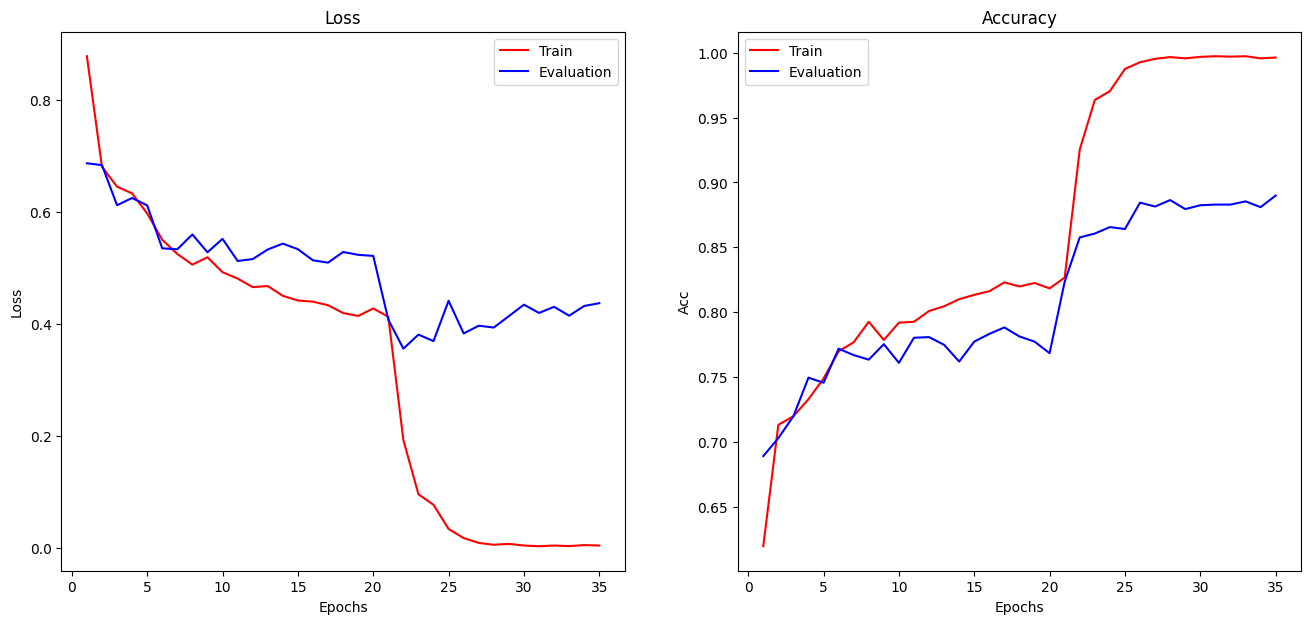

In [65]:
#changing to appropriate format for matplotlib
train_loss = torch.tensor(hist['train_loss'])
val_loss = torch.tensor(hist['val_loss'])
train_acc = torch.tensor(hist['train_acc'])
val_acc =  torch.tensor(hist['val_acc'])


# plot training curves
epochs = range(1, len(hist['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(16,7))
ax[0].plot(epochs, train_loss, 'r-', label='Train')
ax[0].plot(epochs, val_loss , 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, train_acc, 'r-', label='Train')
ax[1].plot(epochs, val_acc , 'b-', label='Evaluation')           
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()
plt.show()

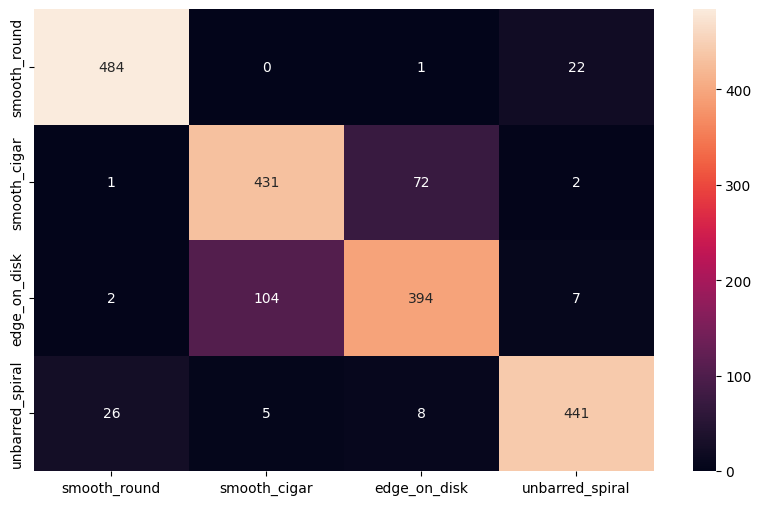

In [66]:
#create confusion matrix
cf_matrix = confusion_matrix(lab_true, lab_pred)
classes = GalaxyMNIST.classes
df_cm = pd.DataFrame(cf_matrix 
                     , index = [i for i in classes], columns = [i for i in classes])

#plot confusion matrix
plt.figure(figsize = (10,6))
sn.heatmap(df_cm, annot=True, fmt = ".0f")